# Two-dimensional data with bottleneck

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Create sklearn.datasets.make_moons() data sets of varying sizes

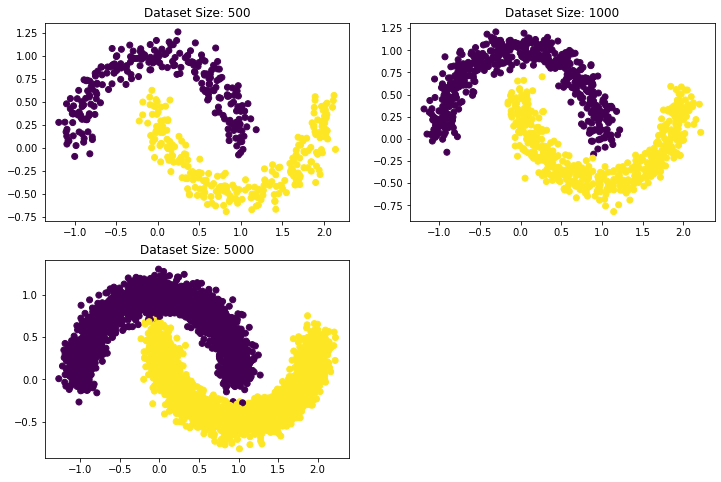

In [28]:
dataset_sizes = [ 500, 1000, 5000]

# Generate datasets of varying sizes
train_datasets = {}
val_datasets = {}
datasets = {}

for size in dataset_sizes:
    X, y = make_moons(n_samples=size, noise=0.1)
    datasets[size] = {'X': X, 'y': y}
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    train_datasets[size] = {'X': torch.FloatTensor(X_train), 'y': y_train}
    val_datasets[size] = {'X': torch.FloatTensor(X_test), 'y': y_test}

# Visualize the training datasets
plt.figure(figsize=(12, 8))

for i, size in enumerate(dataset_sizes, 1):
    plt.subplot(2, 2, i)
    plt.scatter(datasets[size]['X'][:, 0], datasets[size]['X'][:, 1], c=datasets[size]['y'])
    plt.title(f'Dataset Size: {size}')

plt.show()

Next we implement the Autoencoder class with variable length of hidden layers

In [3]:
# Autoencoder model class
class Autoencoder(nn.Module):
    def __init__(self, input_size, bottleneck_size, hidden_size, layers):
        super(Autoencoder, self).__init__()
        
        encoder_layers = []
        decoder_layers = []
        
        encoder_layers.append(nn.Linear(input_size, hidden_size))
        encoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(bottleneck_size, hidden_size))
        decoder_layers.append(nn.ReLU())

        # Encoder and Decoder layers
        for _ in range(layers):
            encoder_layers.append(nn.Linear(hidden_size, hidden_size))
            encoder_layers.append(nn.ReLU())
            decoder_layers.append(nn.Linear(hidden_size, hidden_size))
            decoder_layers.append(nn.ReLU())
            
        encoder_layers.append(nn.Linear(hidden_size, bottleneck_size)) 
        decoder_layers.append(nn.Linear(hidden_size, input_size))
        
        # Combine encoder and decoder
        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Lets define the training and testing function with the demanded parameters

In [34]:
# Training function
def train_autoencoder(model, train_datasets, val_datasets, dataset_size=1000, num_epochs=100, batch_size=32, learning_rate=0.001):
    
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Data loader
    
    train_loader = torch.utils.data.DataLoader(train_datasets[dataset_size]['X'], batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_datasets[dataset_size]['X'], batch_size=batch_size, shuffle=True)
    
    epoch_train_losses = []  # List to store the loss for each epoch
    epoch_val_losses = []  # List to store the loss for each epoch
    for epoch in range(num_epochs):
        train_batch_losses = []
        val_batch_losses = []
        for batch in train_loader:
            # Forward pass
            outputs = model(batch)

            # Compute the loss
            loss = criterion(outputs, batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_batch_losses.append(loss.item())
        
        for batch in val_loader:
            outputs = model(batch)
            loss = criterion(outputs, batch)
            val_batch_losses.append(loss.item())

        # Calculate and store the mean loss for the epoch
        epoch_train_loss = sum(train_batch_losses) / len(train_batch_losses)
        epoch_train_losses.append(epoch_train_loss)

        epoch_val_loss = sum(val_batch_losses) / len(val_batch_losses)
        epoch_val_losses.append(epoch_val_loss)
        # Print the mean loss every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_train_loss:.4f}')
    return epoch_train_losses, epoch_val_losses

Checking training functionality:

In [24]:
# Create and train the autoencoder
input_size = 2
bottleneck_size = 1
hidden_size = 100
layers = 2
dataset_size=1000


autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size, layers)
_,_ = train_autoencoder(autoencoder, train_datasets, dataset_size=1000,num_epochs=200)

Epoch [10/200], Loss: 2.5318
Epoch [20/200], Loss: 0.6555
Epoch [30/200], Loss: 0.3839
Epoch [40/200], Loss: 0.2662
Epoch [50/200], Loss: 0.2075
Epoch [60/200], Loss: 0.1883
Epoch [70/200], Loss: 0.1771
Epoch [80/200], Loss: 0.1527
Epoch [90/200], Loss: 0.1442
Epoch [100/200], Loss: 0.1340
Epoch [110/200], Loss: 0.1357
Epoch [120/200], Loss: 0.1355
Epoch [130/200], Loss: 0.1306
Epoch [140/200], Loss: 0.1286
Epoch [150/200], Loss: 0.1323
Epoch [160/200], Loss: 0.1316
Epoch [170/200], Loss: 0.1257
Epoch [180/200], Loss: 0.1424
Epoch [190/200], Loss: 0.1290
Epoch [200/200], Loss: 0.1280
Mean squared reconstruction loss on test dataset: 0.008382718078792095


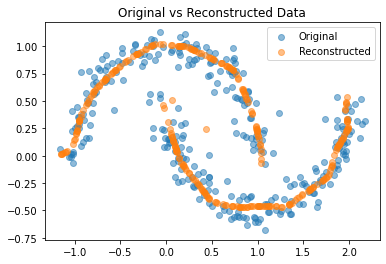

In [6]:
# Function to visualize original and reconstructed data
def visualize_results(model, data):
    with torch.no_grad():
        reconstructed_data = model(data)

    # Convert PyTorch tensors to numpy arrays
    data_np = data.numpy()
    reconstructed_np = reconstructed_data.numpy()

    # Plot original and reconstructed data
    plt.scatter(data_np[:, 0], data_np[:, 1], label='Original', alpha=0.5)
    plt.scatter(reconstructed_np[:, 0], reconstructed_np[:, 1], label='Reconstructed', alpha=0.5)
    plt.title('Original vs Reconstructed Data')
    plt.legend()
    plt.show()

# Visualize results on the test dataset
visualize_results(autoencoder, val_datasets[dataset_size]['X'])

## 1.1 Hyperparameter search
In order to not a have a exploding search space, we first analyze the number of epochs in relation to the dataset size

In [47]:
# Define the hyperparameter values to explore
hidden_sizes = [50, 100, 200]
layers = [2, 5, 10]
learning_rates = [0.0005, 0.001, 0.002 ,0.003]
epochs = [100,250,500]
dataset_sizes = [500, 1000, 5000]

Epoch [10/400], Loss: 0.0627
Epoch [20/400], Loss: 0.0409
Epoch [30/400], Loss: 0.0375
Epoch [40/400], Loss: 0.0314
Epoch [50/400], Loss: 0.0245
Epoch [60/400], Loss: 0.0161
Epoch [70/400], Loss: 0.0148
Epoch [80/400], Loss: 0.0097
Epoch [90/400], Loss: 0.0077
Epoch [100/400], Loss: 0.0090
Epoch [110/400], Loss: 0.0107
Epoch [120/400], Loss: 0.0075
Epoch [130/400], Loss: 0.0070
Epoch [140/400], Loss: 0.0076
Epoch [150/400], Loss: 0.0073
Epoch [160/400], Loss: 0.0067
Epoch [170/400], Loss: 0.0062
Epoch [180/400], Loss: 0.0071
Epoch [190/400], Loss: 0.0061
Epoch [200/400], Loss: 0.0062
Epoch [210/400], Loss: 0.0073
Epoch [220/400], Loss: 0.0070
Epoch [230/400], Loss: 0.0069
Epoch [240/400], Loss: 0.0059
Epoch [250/400], Loss: 0.0065
Epoch [260/400], Loss: 0.0062
Epoch [270/400], Loss: 0.0063
Epoch [280/400], Loss: 0.0059
Epoch [290/400], Loss: 0.0057
Epoch [300/400], Loss: 0.0059
Epoch [310/400], Loss: 0.0060
Epoch [320/400], Loss: 0.0063
Epoch [330/400], Loss: 0.0057
Epoch [340/400], Lo

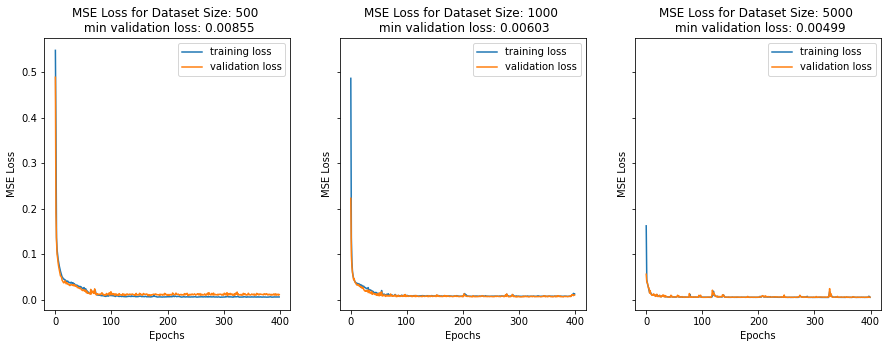

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i, dataset_size in enumerate(dataset_sizes):
    autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size = 100, layers = 2)
    train_losses, val_losses = train_autoencoder(autoencoder, train_datasets,val_datasets, dataset_size=dataset_size, num_epochs=400)
    axes[i].plot(train_losses, label='training loss')
    axes[i].plot(val_losses, label='validation loss')
    axes[i].set_title('MSE Loss for Dataset Size: {} \n min validation loss: {:.5f}'.format(dataset_size, min(val_losses)))
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel('MSE Loss')
    axes[i].legend()

    

The best performance is achieved for the biggest dataset, however the dataset with 1000 entries is almost just as good and substantially faster. Therefore, we choose the continue with this medium sized dataset and let the training run to 200 epochs for now

Epoch [10/300], Loss: 0.0442
Epoch [20/300], Loss: 0.0336
Epoch [30/300], Loss: 0.0310
Epoch [40/300], Loss: 0.0282
Epoch [50/300], Loss: 0.0202
Epoch [60/300], Loss: 0.0155
Epoch [70/300], Loss: 0.0144
Epoch [80/300], Loss: 0.0124
Epoch [90/300], Loss: 0.0114
Epoch [100/300], Loss: 0.0098
Epoch [110/300], Loss: 0.0094
Epoch [120/300], Loss: 0.0089
Epoch [130/300], Loss: 0.0094
Epoch [140/300], Loss: 0.0088
Epoch [150/300], Loss: 0.0095
Epoch [160/300], Loss: 0.0077
Epoch [170/300], Loss: 0.0077
Epoch [180/300], Loss: 0.0078
Epoch [190/300], Loss: 0.0095
Epoch [200/300], Loss: 0.0089
Epoch [210/300], Loss: 0.0080
Epoch [220/300], Loss: 0.0073
Epoch [230/300], Loss: 0.0072
Epoch [240/300], Loss: 0.0076
Epoch [250/300], Loss: 0.0078
Epoch [260/300], Loss: 0.0074
Epoch [270/300], Loss: 0.0077
Epoch [280/300], Loss: 0.0075
Epoch [290/300], Loss: 0.0075
Epoch [300/300], Loss: 0.0073
Epoch [10/300], Loss: 0.0368
Epoch [20/300], Loss: 0.0291
Epoch [30/300], Loss: 0.0219
Epoch [40/300], Loss: 

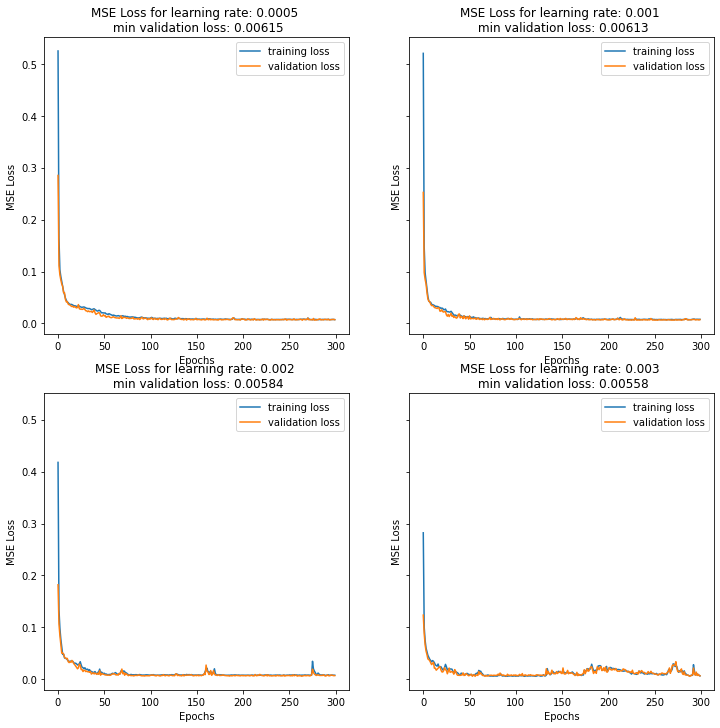

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)
for i, learning_rate in enumerate(learning_rates):
    autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size = 100, layers = 2)
    train_losses, val_losses = train_autoencoder(autoencoder, train_datasets,val_datasets, dataset_size=1000, num_epochs=300, learning_rate=learning_rate)
    
    # Use two indices to access the correct subplot
    row = i // 2  # Integer division to get the row index
    col = i % 2   # Modulo operation to get the column index
    
    axes[row, col].plot(train_losses, label='training loss')
    axes[row, col].plot(val_losses, label='validation loss')
    axes[row, col].set_title('MSE Loss for learning rate: {} \n min validation loss: {:.5f}'.format(learning_rate, min(val_losses)))
    axes[row, col].set_xlabel('Epochs')
    axes[row, col].set_ylabel('MSE Loss')
    axes[row, col].legend()

We see, with this autoencoder architecture, the learning rate does not have a great impact on training results. Nevertheless, training with larger learning rates is faster but we one can see, that the training is more unstable as well. Thus, we continue with a learning rate of 0.001 for 200 epochs. Now lets see, if we can improve the network hyperparameters

Epoch [10/200], Loss: 0.0534
Epoch [20/200], Loss: 0.0364
Epoch [30/200], Loss: 0.0313
Epoch [40/200], Loss: 0.0271
Epoch [50/200], Loss: 0.0220
Epoch [60/200], Loss: 0.0175
Epoch [70/200], Loss: 0.0146
Epoch [80/200], Loss: 0.0121
Epoch [90/200], Loss: 0.0113
Epoch [100/200], Loss: 0.0120
Epoch [110/200], Loss: 0.0093
Epoch [120/200], Loss: 0.0091
Epoch [130/200], Loss: 0.0094
Epoch [140/200], Loss: 0.0084
Epoch [150/200], Loss: 0.0087
Epoch [160/200], Loss: 0.0085
Epoch [170/200], Loss: 0.0080
Epoch [180/200], Loss: 0.0087
Epoch [190/200], Loss: 0.0080
Epoch [200/200], Loss: 0.0083
Epoch [10/200], Loss: 0.0694
Epoch [20/200], Loss: 0.0517
Epoch [30/200], Loss: 0.0366
Epoch [40/200], Loss: 0.0279
Epoch [50/200], Loss: 0.0237
Epoch [60/200], Loss: 0.0216
Epoch [70/200], Loss: 0.0192
Epoch [80/200], Loss: 0.0196
Epoch [90/200], Loss: 0.0196
Epoch [100/200], Loss: 0.0151
Epoch [110/200], Loss: 0.0162
Epoch [120/200], Loss: 0.0089
Epoch [130/200], Loss: 0.0078
Epoch [140/200], Loss: 0.007

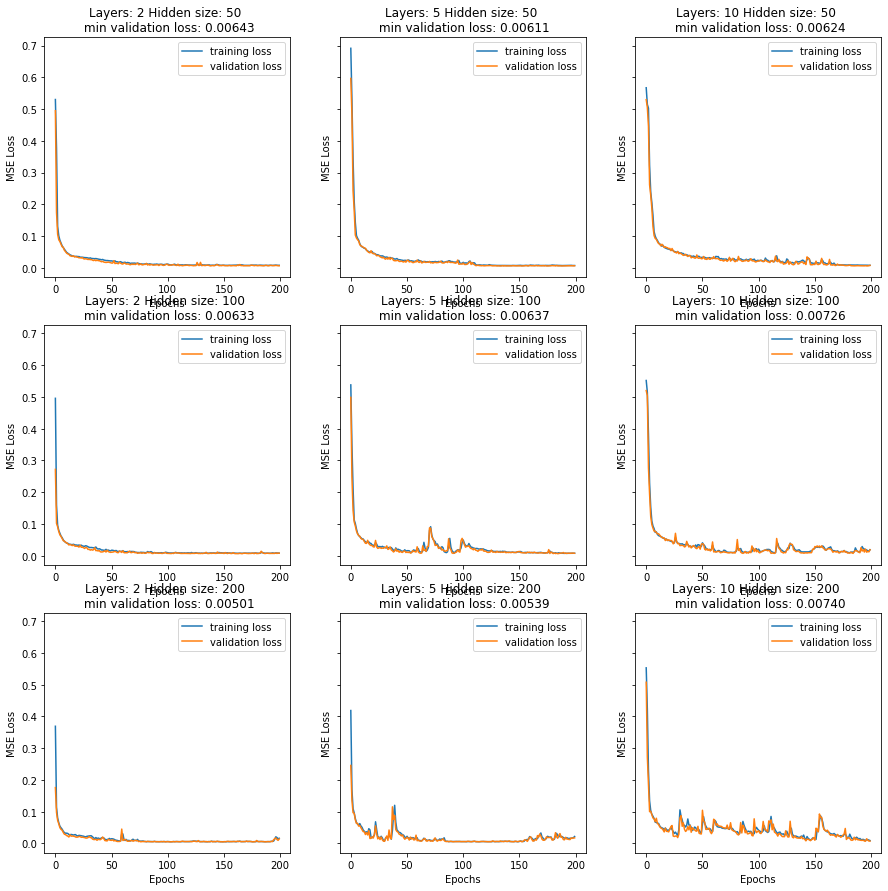

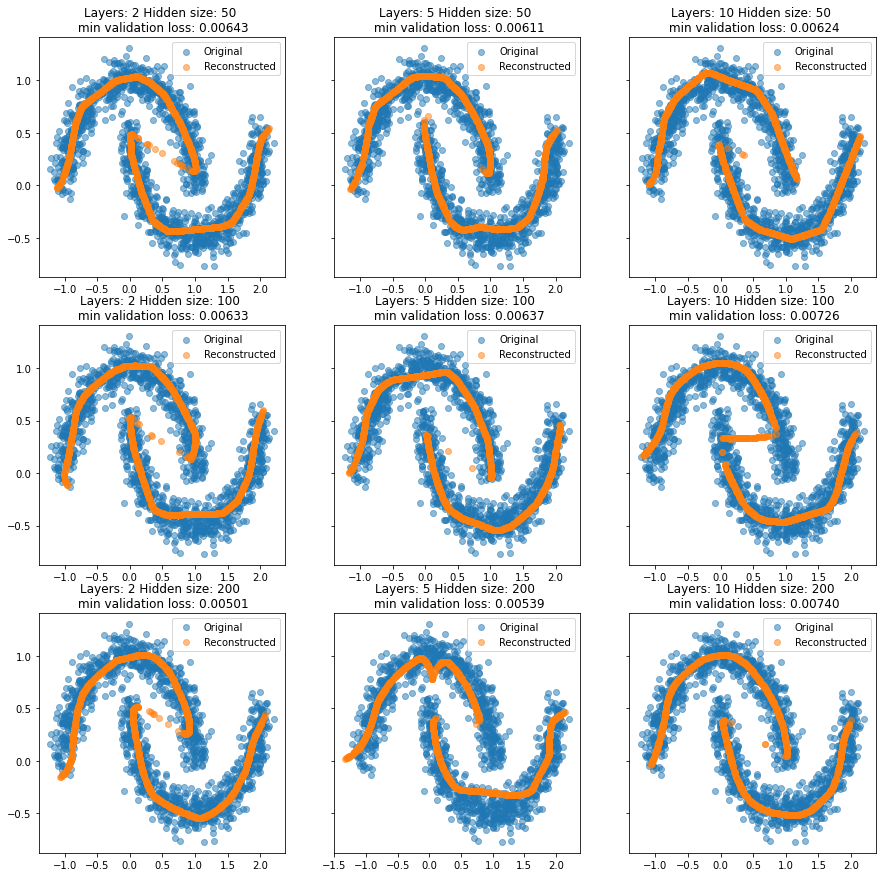

In [54]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharey=True)
fig_2, axes_2 = plt.subplots(3, 3, figsize=(15, 15), sharey=True)

for i, hidden_size in enumerate(hidden_sizes):
    for j, num_layers in enumerate(layers):
        autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size = hidden_size, layers = num_layers)
        train_losses, val_losses = train_autoencoder(autoencoder, train_datasets,val_datasets, dataset_size=1000, num_epochs=200, learning_rate=0.001)
        
        axes[i, j].plot(train_losses, label='training loss')
        axes[i, j].plot(val_losses, label='validation loss')
        axes[i, j].set_title('Layers: {} Hidden size: {} \n min validation loss: {:.5f}'.format(num_layers, hidden_size, min(val_losses)))
        axes[i, j].set_xlabel('Epochs')
        axes[i, j].set_ylabel('MSE Loss')
        axes[i, j].legend()

        val_data = val_datasets[dataset_size]['X']
        with torch.no_grad():
            reconstructed_data = autoencoder(val_data)
        
        # Convert PyTorch tensors to numpy arrays
        data_np = val_data.numpy()
        reconstructed_np = reconstructed_data.numpy()

        # Plot original and reconstructed data
        axes_2[i, j].scatter(data_np[:, 0], data_np[:, 1], label='Original', alpha=0.5)
        axes_2[i, j].scatter(reconstructed_np[:, 0], reconstructed_np[:, 1], label='Reconstructed', alpha=0.5)
        axes_2[i, j].set_title('Layers: {} Hidden size: {} \n min validation loss: {:.5f}'.format(num_layers, hidden_size, min(val_losses)))
        axes_2[i, j].legend()

Epoch [10/150], Loss: 0.0614
Epoch [20/150], Loss: 0.0370
Epoch [30/150], Loss: 0.0332
Epoch [40/150], Loss: 0.0302
Epoch [50/150], Loss: 0.0280
Epoch [60/150], Loss: 0.0221
Epoch [70/150], Loss: 0.0166
Epoch [80/150], Loss: 0.0135
Epoch [90/150], Loss: 0.0118
Epoch [100/150], Loss: 0.0109
Epoch [110/150], Loss: 0.0110
Epoch [120/150], Loss: 0.0093
Epoch [130/150], Loss: 0.0090
Epoch [140/150], Loss: 0.0091
Epoch [150/150], Loss: 0.0089
Epoch [10/150], Loss: 0.0758
Epoch [20/150], Loss: 0.0527
Epoch [30/150], Loss: 0.0411
Epoch [40/150], Loss: 0.0302
Epoch [50/150], Loss: 0.0261
Epoch [60/150], Loss: 0.0188
Epoch [70/150], Loss: 0.0156
Epoch [80/150], Loss: 0.0109
Epoch [90/150], Loss: 0.0113
Epoch [100/150], Loss: 0.0096
Epoch [110/150], Loss: 0.0130
Epoch [120/150], Loss: 0.0182
Epoch [130/150], Loss: 0.0130
Epoch [140/150], Loss: 0.0068
Epoch [150/150], Loss: 0.0059
Epoch [10/150], Loss: 0.0803
Epoch [20/150], Loss: 0.0549
Epoch [30/150], Loss: 0.0393
Epoch [40/150], Loss: 0.0308
Ep

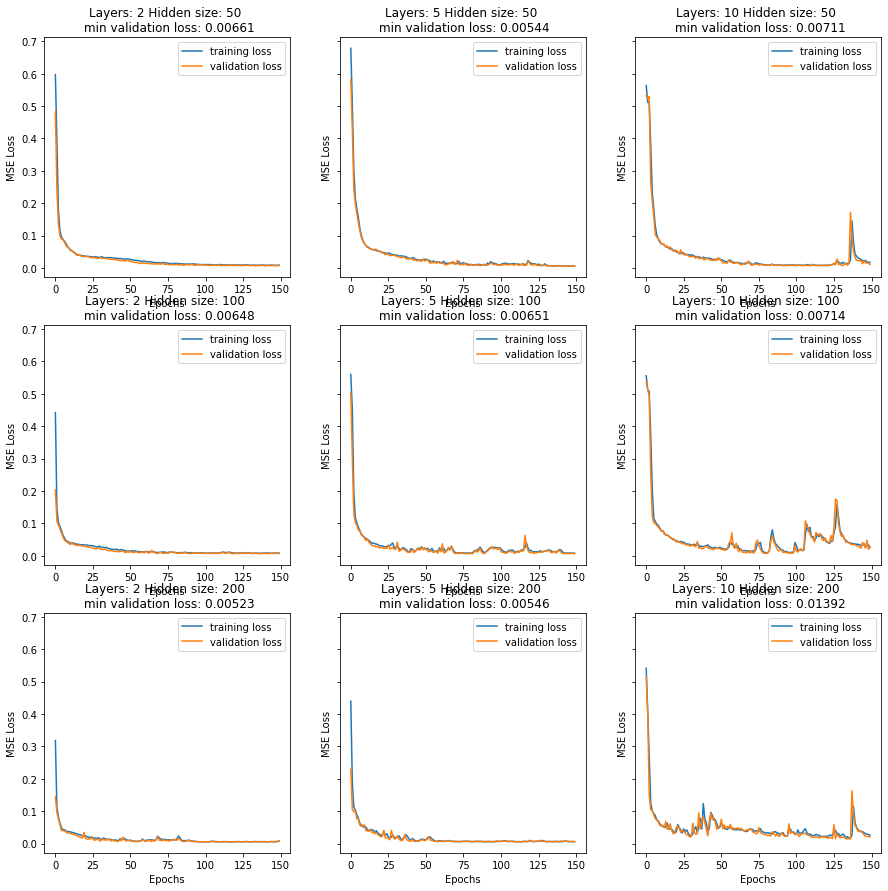

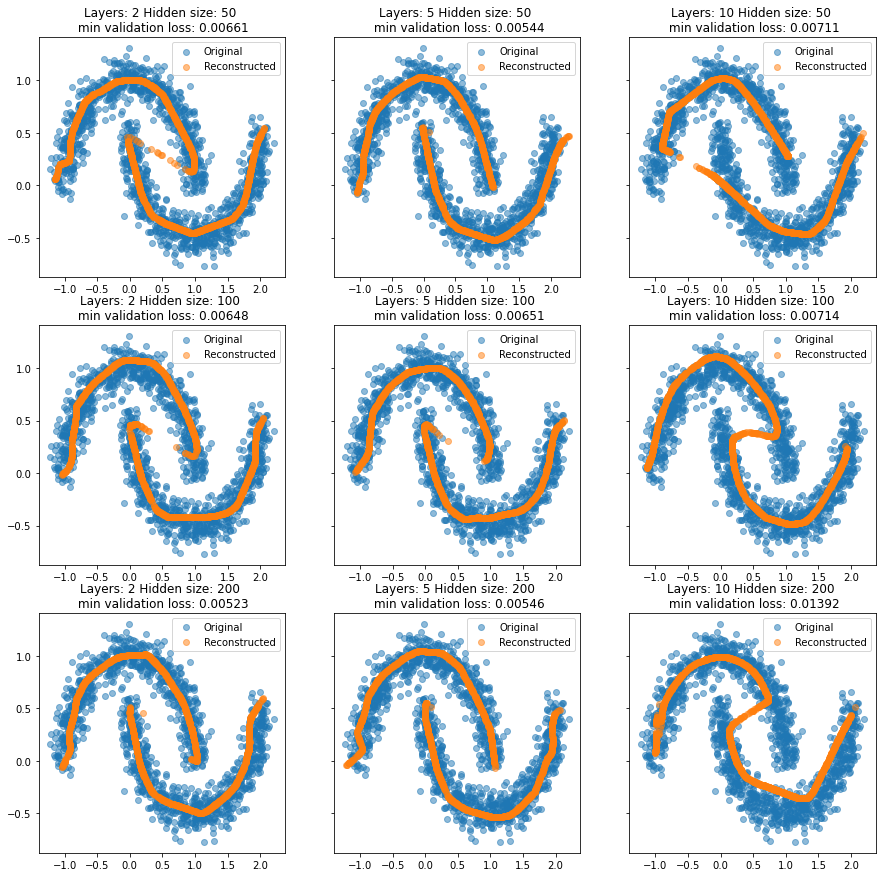

In [61]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharey=True)
fig_2, axes_2 = plt.subplots(3, 3, figsize=(15, 15), sharey=True)

for i, hidden_size in enumerate(hidden_sizes):
    for j, num_layers in enumerate(layers):
        autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size = hidden_size, layers = num_layers)
        train_losses, val_losses = train_autoencoder(autoencoder, train_datasets,val_datasets, dataset_size=1000, num_epochs=150, learning_rate=0.001)
        
        axes[i, j].plot(train_losses, label='training loss')
        axes[i, j].plot(val_losses, label='validation loss')
        axes[i, j].set_title('Layers: {} Hidden size: {} \n min validation loss: {:.5f}'.format(num_layers, hidden_size, min(val_losses)))
        axes[i, j].set_xlabel('Epochs')
        axes[i, j].set_ylabel('MSE Loss')
        axes[i, j].legend()

        val_data = val_datasets[dataset_size]['X']
        with torch.no_grad():
            reconstructed_data = autoencoder(val_data)
        
        # Convert PyTorch tensors to numpy arrays
        data_np = val_data.numpy()
        reconstructed_np = reconstructed_data.numpy()

        # Plot original and reconstructed data
        axes_2[i, j].scatter(data_np[:, 0], data_np[:, 1], label='Original', alpha=0.5)
        axes_2[i, j].scatter(reconstructed_np[:, 0], reconstructed_np[:, 1], label='Reconstructed', alpha=0.5)
        axes_2[i, j].set_title('Layers: {} Hidden size: {} \n min validation loss: {:.5f}'.format(num_layers, hidden_size, min(val_losses)))
        axes_2[i, j].legend()

## 2.2
Repeating the same trainig with all dataset sizes

Epoch [10/150], Loss: 0.1774
Epoch [20/150], Loss: 0.0777
Epoch [30/150], Loss: 0.0608
Epoch [40/150], Loss: 0.0524
Epoch [50/150], Loss: 0.0466
Epoch [60/150], Loss: 0.0404
Epoch [70/150], Loss: 0.0357
Epoch [80/150], Loss: 0.0318
Epoch [90/150], Loss: 0.0290
Epoch [100/150], Loss: 0.0278
Epoch [110/150], Loss: 0.0287
Epoch [120/150], Loss: 0.0231
Epoch [130/150], Loss: 0.0230
Epoch [140/150], Loss: 0.0223
Epoch [150/150], Loss: 0.0249
Epoch [10/150], Loss: 0.0638
Epoch [20/150], Loss: 0.0448
Epoch [30/150], Loss: 0.0293
Epoch [40/150], Loss: 0.0241
Epoch [50/150], Loss: 0.0239
Epoch [60/150], Loss: 0.0166
Epoch [70/150], Loss: 0.0142
Epoch [80/150], Loss: 0.0133
Epoch [90/150], Loss: 0.0117
Epoch [100/150], Loss: 0.0132
Epoch [110/150], Loss: 0.0122
Epoch [120/150], Loss: 0.0122
Epoch [130/150], Loss: 0.0108
Epoch [140/150], Loss: 0.0157
Epoch [150/150], Loss: 0.0097
Epoch [10/150], Loss: 0.0248
Epoch [20/150], Loss: 0.0123
Epoch [30/150], Loss: 0.0100
Epoch [40/150], Loss: 0.0070
Ep

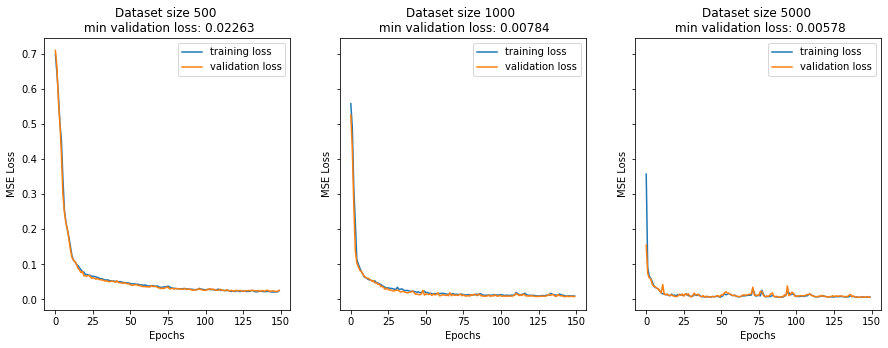

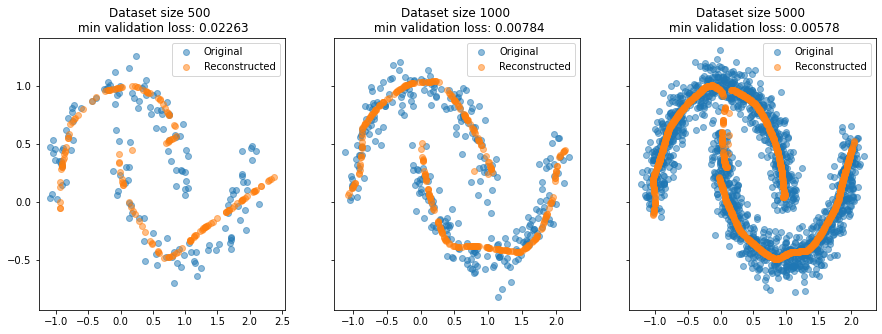

In [60]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig_2, axes_2 = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, dataset_size in enumerate(dataset_sizes):
        autoencoder = Autoencoder(input_size, bottleneck_size, hidden_size = 50, layers = 5)
        train_losses, val_losses = train_autoencoder(autoencoder, train_datasets,val_datasets, dataset_size=dataset_size, num_epochs=150, learning_rate=0.001)
        
        axes[i].plot(train_losses, label='training loss')
        axes[i].plot(val_losses, label='validation loss')
        axes[i].set_title('Dataset size {} \n min validation loss: {:.5f}'.format(dataset_size, min(val_losses)))
        axes[i].set_xlabel('Epochs')
        axes[i].set_ylabel('MSE Loss')
        axes[i].legend()

        val_data = val_datasets[dataset_size]['X']
        with torch.no_grad():
            reconstructed_data = autoencoder(val_data)
        
        # Convert PyTorch tensors to numpy arrays
        data_np = val_data.numpy()
        reconstructed_np = reconstructed_data.numpy()

        # Plot original and reconstructed data
        axes_2[i].scatter(data_np[:, 0], data_np[:, 1], label='Original', alpha=0.5)
        axes_2[i].scatter(reconstructed_np[:, 0], reconstructed_np[:, 1], label='Reconstructed', alpha=0.5)
        axes_2[i].set_title('Dataset size {} \n min validation loss: {:.5f}'.format(dataset_size, min(val_losses)))
        axes_2[i].legend()

## 2.3